# Answering Business Questions with SQL

This analysis will use the SQLite module in Python to answer business questions about the Chinook record store.

In [1]:
import sqlite3
import pandas as pd
import matplotlib
%matplotlib inline

# function to execute SQL queries agains the chinook database
def run_query(query):
    with sqlite3.connect('chinook.db') as connection:
        # return the query results as a dataframe
        query_result = pd.read_sql(query, connection)
        return query_result

# function to execute SQL commands that don't return a table
def run_command(q):
    with sqlite3.connect('chinook.db') as conn:
        conn.isolation_level = None
        conn.execute(q)

# function to display a list of all tables and view in the database
def show_tables():
    sql_query = """
        SELECT name, type
        FROM sqlite_master
        WHERE type IN ('table', 'view')
    """
    return run_query(sql_query)

In [2]:
# validate the output of the current database tables and views
show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


In [3]:
# return the number of tracks sold per genre in the U.S.
qry = """
    SELECT g.name Genre, COUNT(*) tracks_sold
    FROM track t
    INNER JOIN invoice_line il
    ON t.track_id = il.track_id
    INNER JOIN invoice i
    ON il.invoice_id = i.invoice_id
    INNER JOIN customer c
    ON i.customer_id = c.customer_id
    INNER JOIN genre g
    on t.genre_id = g.genre_id
    WHERE c.country = "USA"
    GROUP BY g.name
    ORDER BY tracks_sold DESC
"""

top_genres_usa = run_query(qry)

In [4]:
# visualize the output
top_genres_usa

,Genre,tracks_sold
0,Rock,561
1,Alternative & Punk,130
2,Metal,124
3,R&B/Soul,53
4,Blues,36
5,Alternative,35
6,Latin,22
7,Pop,22
8,Hip Hop/Rap,20
9,Jazz,14


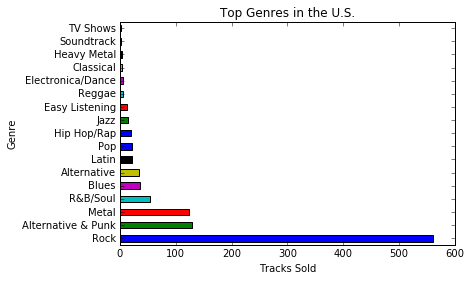

In [5]:
# set the dataframe index to Genre
top_genres_usa.set_index('Genre')

# create a visualization for the top U.S. genres
top_genres_usa.plot(x='Genre', y='tracks_sold', kind='barh', legend=False)
matplotlib.pyplot.xlabel('Tracks Sold')
matplotlib.pyplot.title('Top Genres in the U.S.')

### Top Genres in the U.S.

As shown in the visualization above, Rock is the highest selling genre in the by a margin of over 400 track sales, followed by Alternative & Punk, with Metal being 3rd.

In [6]:
# return the sales dollars for each support agent
sql_q = """
    SELECT e.first_name || ' ' || e.last_name Employee,
        SUM(i.total) Sales
    FROM invoice i
    INNER JOIN customer c
    ON i.customer_id = c.customer_id
    INNER JOIN employee e
    ON c.support_rep_id = e.employee_id
    GROUP BY Employee
    ORDER BY Sales DESC
"""

sales_per_rep = run_query(sql_q)

# display results
sales_per_rep

,Employee,Sales
0,Jane Peacock,1731.51
1,Margaret Park,1584.00
2,Steve Johnson,1393.92


(array([0, 1, 2]), <a list of 3 Text xticklabel objects>)

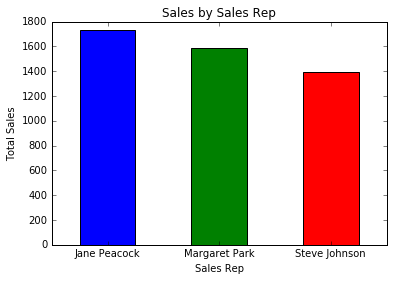

In [7]:
# visualize the results
sales_per_rep.plot(x='Employee', y='Sales', kind='bar', legend=False)
matplotlib.pyplot.xlabel('Sales Rep')
matplotlib.pyplot.ylabel('Total Sales')
matplotlib.pyplot.title('Sales by Sales Rep')
matplotlib.pyplot.xticks(rotation='horizontal')

### Sales by Sales Rep

As shown in the visualization above, Jane high the highest sales, followed by Margaret, and then Steve. Although there are more employees at the Chinook record store, Jane, Margaret, and Steve are the only Sales Reps, so they are the only employees that have made any sales, and therefore, only the records for these employees are showing for the query (due to using INNER JOIN).

In [8]:
# return customer and sales data for each country
sl_q = """
    SELECT DISTINCT(countries.country), 
        countries.Num_Customers, 
        inv.Total_Sales,
        ROUND((inv.Total_Sales / countries.Num_Customers), 2) Value_Per_Customer
    FROM (
        SELECT c.customer_id, 
            c.country, 
            COUNT(*) Num_Customers
        FROM customer c
        GROUP BY c.country
        ORDER BY Num_Customers DESC
    ) countries
    INNER JOIN (
        SELECT cust.customer_id, SUM(i.total) AS Total_Sales
        FROM invoice i
        INNER JOIN customer cust
        ON i.customer_id = cust.customer_id
        GROUP BY cust.customer_id
    ) inv
    ON countries.customer_id = inv.customer_id
"""

country_data = run_query(sl_q)

# display results
country_data

,country,Num_Customers,Total_Sales,Value_Per_Customer
0,USA,13,72.27,5.56
1,Canada,8,75.24,9.41
2,Brazil,5,106.92,21.38
3,France,5,73.26,14.65
4,Germany,4,73.26,18.31
5,United Kingdom,3,79.20,26.40
6,Czech Republic,2,128.70,64.35
7,India,2,71.28,35.64
8,Portugal,2,82.17,41.09
9,Argentina,1,39.60,39.60


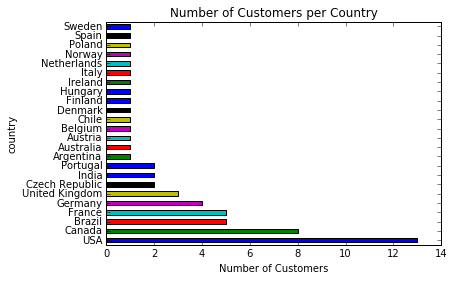

In [9]:
# visualize number of customers per country
country_data.plot(x='country', y='Num_Customers', kind='barh', legend=False)
matplotlib.pyplot.xlabel('Number of Customers')
matplotlib.pyplot.title('Number of Customers per Country')

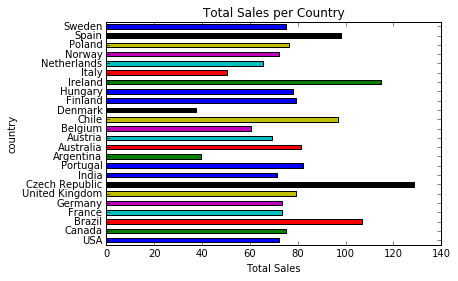

In [10]:
# visualize total sales per country
country_data.plot(x='country', y='Total_Sales', kind='barh', legend=False)
matplotlib.pyplot.xlabel('Total Sales')
matplotlib.pyplot.title('Total Sales per Country')

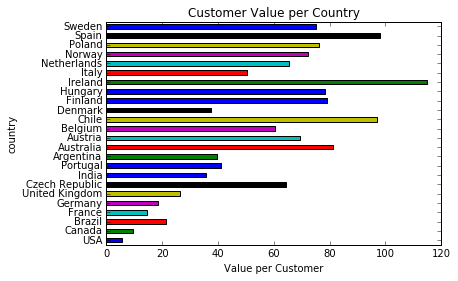

In [11]:
# visualize value per customer per country
country_data.plot(x='country', y='Value_Per_Customer', kind='barh', legend=False)
matplotlib.pyplot.xlabel('Value per Customer')
matplotlib.pyplot.title('Customer Value per Country')

###  Customer and Sales Analysis

As shown in the visualizations above, the highest number of customers are in the U.S., Canada, and Brazil. The total sales are highest in Czech Republic, Ireland, and Brazil, whereas the value per customer is the highest in Ireland, Spain, and Chile.

Using the data, the recommendation for which countries the Chinook record store should market in would be Brazil (due to third highest sales and third most customers), Chile (due to third most customer value, fifth most sales, and only 1 customer), and Czech Republic (due to most total sales with only 2 customers).